# E-tivity 3 : Gerard O'Rourke, Student number : 24514772
This
workbook is
for E - tivity3.It follows the following structure
1.
The
workbook
environment is setup
1.
The
next
section
has
some
EDA
related
to
this
E - tivity
1.
Each
task
for this E - tivity then follows

Setup

In [480]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import set_config, svm
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler  # needed for data preparation

print(sklearn.__version__)

# needed for changing Ordinal values - see education
pd.set_option("future.no_silent_downcasting", True)
#sklearn.set_config(enable_metadata_routing=True)
set_config(transform_output='pandas')


1.6.1


#### Setup Environment
Load the data and keep a copy

In [481]:
# Load the dataset
df = pd.read_csv("./insurance.csv")

# keep a copy
df_original = df

print('(number of examples, number of attributes): ', df.shape)

(number of examples, number of attributes):  (1338, 7)


EDA

In [482]:
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [483]:
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


In [484]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [485]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [486]:
numerical_attribute = ['age', 'bmi', 'children']

categorical_attribute = ['gender', 'smoker', 'region']

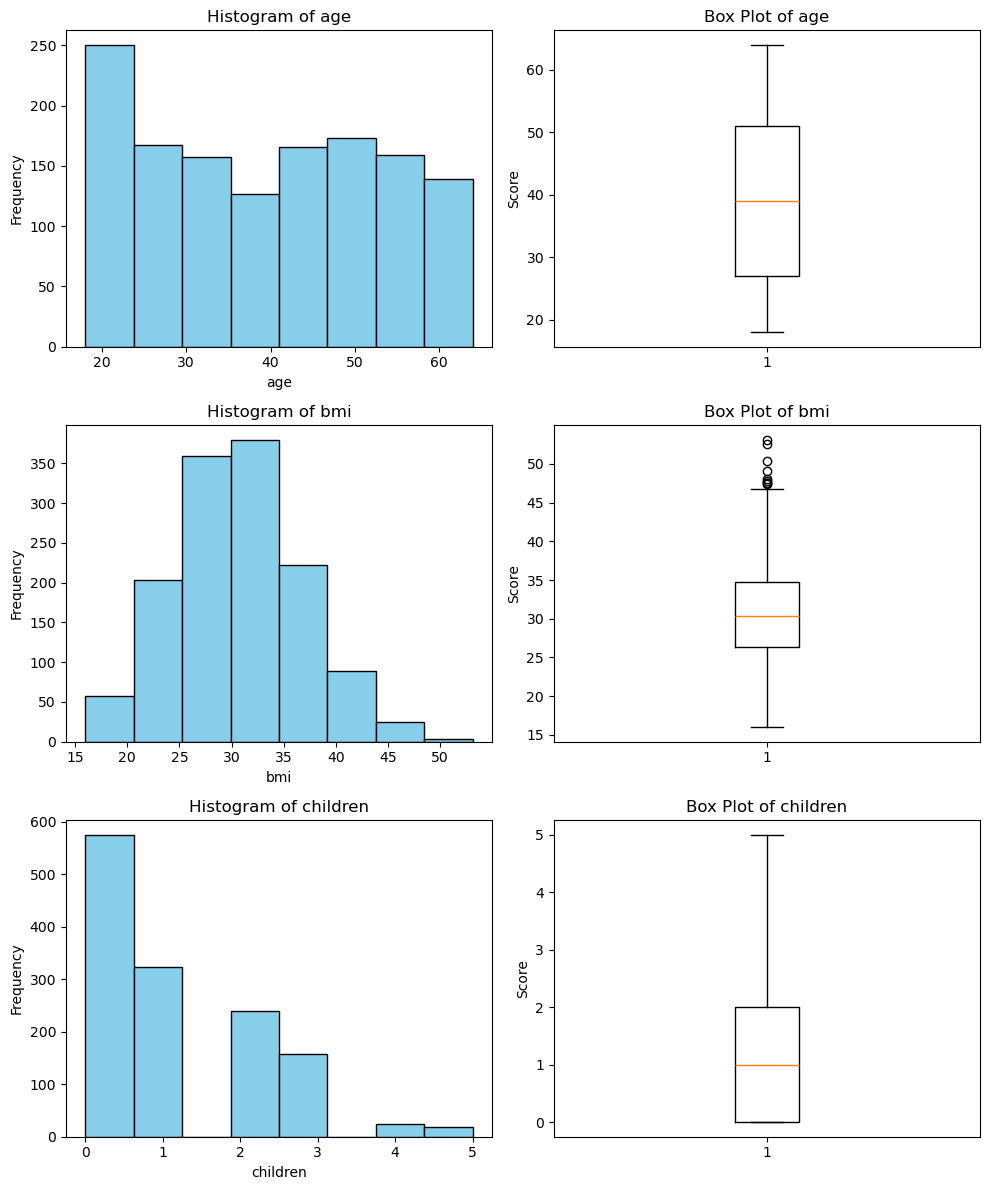

In [487]:
# df.boxplot(column=numerical_attribute)
# Set up the figure with two subplots side by side
fig, axes = plt.subplots(nrows=len(numerical_attribute), ncols=2, figsize=(10, 4 * len(numerical_attribute)))

for row, attribute in enumerate(numerical_attribute):
	# Histogram
	axes[row, 0].hist(df[attribute], bins=8, color='skyblue', edgecolor='black')
	axes[row, 0].set_title(f'Histogram of {attribute}')
	axes[row, 0].set_xlabel(attribute)
	axes[row, 0].set_ylabel('Frequency')

	# Box plot
	axes[row, 1].boxplot(df[attribute], vert=True)
	axes[row, 1].set_title(f'Box Plot of {attribute}')
	axes[row, 1].set_ylabel('Score')

# Display
plt.tight_layout()
plt.show()


In [488]:
df['gender'].value_counts()

gender
male      676
female    662
Name: count, dtype: int64

In [489]:
df['smoker'].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [490]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

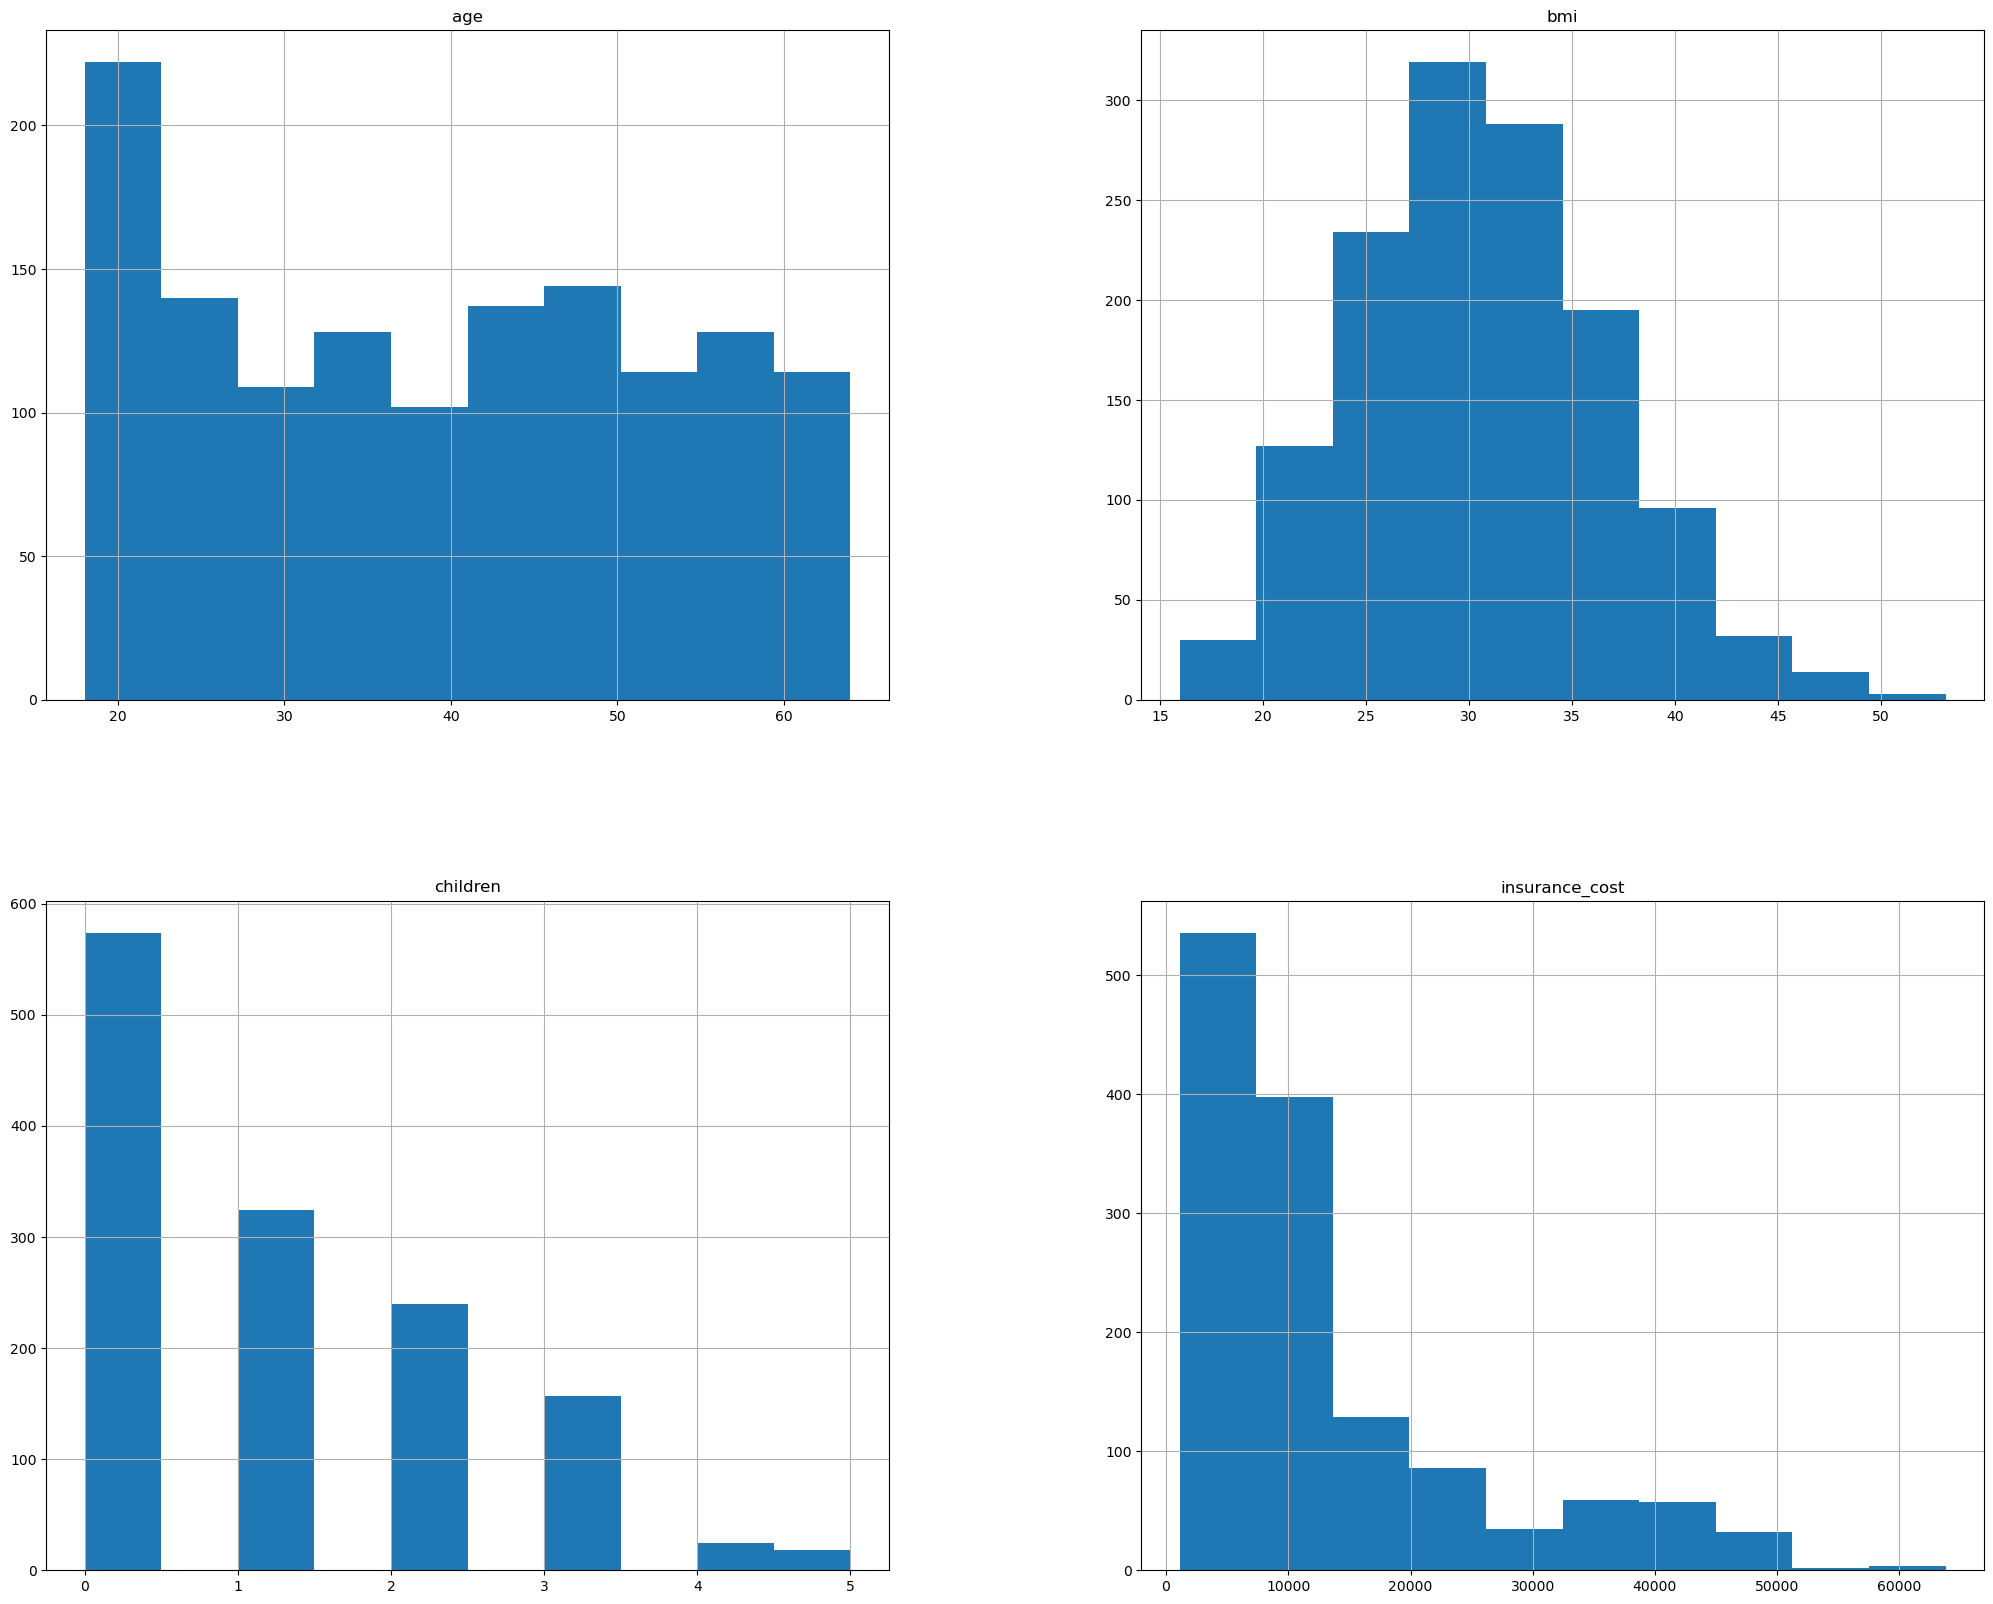

In [491]:
df.select_dtypes(include='number').hist(bins=10, figsize=(25, 20))
plt.show()

|Type| Attribute | Has Zeros | Outliers | Skewed | Map Values | Imput | Scale| One Hot Encode |Comment|
|-----|-----------|----------|----------|--------|------------|-------|------|----------------|----|
|| Age       | No| No |        | No         |            |       | |                | ||
|| Bmi       | No| Yes |        | No         |            |       | |                | ||
|| Children  | Yes|No| Right  | No         |            |       | |                | ||
|| Gender    | No ||        | Yes        |            |       |       |       |                | ||
|| Region    | No   | |        | Yes               |            |       |       |       |                | ||
|| Smoker    | No    ||        | Yes    |            |            |       | |                | ||

## Data PreProcess Pipeline

In [492]:
def map_gender(X):
	X = X.copy()
	X['gender'] = X['gender'].map({'male': 0, 'female': 1})
	return X


def map_smoker(X):
	X = X.copy()
	X['smoker'] = X['smoker'].map({'no': 0, 'yes': 1})
	return X


smoker_mapper = FunctionTransformer(map_smoker)
gender_mapper = FunctionTransformer(map_gender)


In [493]:


###################
num_pipeline = Pipeline(steps=[

	('address_right_skew', ColumnTransformer(
		transformers=[
			('log_transform', FunctionTransformer(np.log1p), ['children'])
		],
		remainder="passthrough"
	)
	 ),
	('scaler', StandardScaler())
]
)

cat_pipeline = Pipeline(steps=[
	('attribute_mappers', ColumnTransformer(
		transformers=[
			('gender_mapper', gender_mapper, ['gender']),
			('smoker_mapper', smoker_mapper, ['smoker']),
			('one-hot', OneHotEncoder(sparse_output=False), ['region'])
		]
	))
])

#
# Use a col transformer to operate on each set separately
#
col_transform = ColumnTransformer(transformers=[
	('num_pipeline', num_pipeline, numerical_attribute),
	('cat_pipeline', cat_pipeline, categorical_attribute)
], remainder='drop', n_jobs=-1)

# create the actual pipeline
preprocess_pipeline = Pipeline(steps=[
	('preprocess', col_transform),

])


In [494]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1)

print(df)

y.describe()



      age  gender     bmi  children smoker     region  insurance_cost
0      18    male  33.770         1     no  southeast      1725.55230
1      18    male  34.100         0     no  southeast      1137.01100
2      18  female  26.315         0     no  northeast      2198.18985
3      18  female  38.665         2     no  northeast      3393.35635
4      18  female  35.625         0     no  northeast      2211.13075
...   ...     ...     ...       ...    ...        ...             ...
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

[1338 rows x 7 columns]


count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: insurance_cost, dtype: float64

In [495]:
X_transformed = preprocess_pipeline.fit_transform(X)
X_transformed.describe()

,num_pipeline__log_transform__children,num_pipeline__remainder__age,num_pipeline__remainder__bmi,cat_pipeline__gender_mapper__gender,cat_pipeline__smoker_mapper__smoker,cat_pipeline__one-hot__region_northeast,cat_pipeline__one-hot__region_northwest,cat_pipeline__one-hot__region_southeast,cat_pipeline__one-hot__region_southwest
count,1.338000e+03,1.338000e+03,1.338000e+03,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,1.062097e-17,-1.699355e-16,-2.230403e-16,0.494768,0.204783,0.242152,0.242900,0.272048,0.242900
std,1.000374e+00,1.000374e+00,1.000374e+00,0.500160,0.403694,0.428546,0.428995,0.445181,0.428995
min,-1.042346e+00,-1.509965e+00,-2.412011e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.042346e+00,-8.691547e-01,-7.164063e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.995936e-01,-1.474046e-02,-4.320880e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.260819e-01,8.396738e-01,6.611572e-01,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2.168022e+00,1.765289e+00,3.685522e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [496]:
X_transformed.head()

,num_pipeline__log_transform__children,num_pipeline__remainder__age,num_pipeline__remainder__bmi,cat_pipeline__gender_mapper__gender,cat_pipeline__smoker_mapper__smoker,cat_pipeline__one-hot__region_northeast,cat_pipeline__one-hot__region_northwest,cat_pipeline__one-hot__region_southeast,cat_pipeline__one-hot__region_southwest
0,0.199594,-1.509965,0.509621,0,0,0.0,0.0,1.0,0.0
1,-1.042346,-1.509965,0.563756,0,0,0.0,0.0,1.0,0.0
2,-1.042346,-1.509965,-0.713331,1,0,1.0,0.0,0.0,0.0
3,0.926082,-1.509965,1.312619,1,0,1.0,0.0,0.0,0.0
4,-1.042346,-1.509965,0.813924,1,0,1.0,0.0,0.0,0.0


In [497]:
X_transformed.tail()

,num_pipeline__log_transform__children,num_pipeline__remainder__age,num_pipeline__remainder__bmi,cat_pipeline__gender_mapper__gender,cat_pipeline__smoker_mapper__smoker,cat_pipeline__one-hot__region_northeast,cat_pipeline__one-hot__region_northwest,cat_pipeline__one-hot__region_southeast,cat_pipeline__one-hot__region_southwest
1333,0.926082,1.765289,0.190555,1,0,1.0,0.0,0.0,0.0
1334,-1.042346,1.765289,-0.619825,1,1,0.0,1.0,0.0,0.0
1335,-1.042346,1.765289,-0.697746,0,0,1.0,0.0,0.0,0.0
1336,0.926082,1.765289,1.032923,0,1,0.0,0.0,1.0,0.0
1337,-1.042346,1.765289,-1.132464,0,1,0.0,0.0,1.0,0.0


In [498]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [499]:


X_transformed = preprocess_pipeline.fit_transform(X)
print(np.isnan(X_transformed).sum())  # Should be 0

print("y variance:", y.var())

# Check shape and type
print("Shape of transformed X:", X_transformed.shape)
print("Type:", type(X_transformed))

# Convert to dense array if sparse (OneHotEncoder can return sparse matrix)
if hasattr(X_transformed, "toarray"):
	X_transformed = X_transformed.toarray()

# Check for NaNs or infs
print("Any NaNs:", np.isnan(X_transformed).any())
print("Any Infs:", np.isinf(X_transformed).any())

# Check variance of columns
variances = np.var(X_transformed, axis=0)
print("Any zero-variance columns:", (variances == 0).any())



num_pipeline__log_transform__children      0
num_pipeline__remainder__age               0
num_pipeline__remainder__bmi               0
cat_pipeline__gender_mapper__gender        0
cat_pipeline__smoker_mapper__smoker        0
cat_pipeline__one-hot__region_northeast    0
cat_pipeline__one-hot__region_northwest    0
cat_pipeline__one-hot__region_southeast    0
cat_pipeline__one-hot__region_southwest    0
dtype: int64
y variance: 146652372.15285486
Shape of transformed X: (1338, 9)
Type: <class 'pandas.core.frame.DataFrame'>
Any NaNs: num_pipeline__log_transform__children      False
num_pipeline__remainder__age               False
num_pipeline__remainder__bmi               False
cat_pipeline__gender_mapper__gender        False
cat_pipeline__smoker_mapper__smoker        False
cat_pipeline__one-hot__region_northeast    False
cat_pipeline__one-hot__region_northwest    False
cat_pipeline__one-hot__region_southeast    False
cat_pipeline__one-hot__region_southwest    False
dtype: bool
Any Infs: 

## Dimension Reduction Setup

In [500]:

N_FEATURES_OPTIONS = [2, 4, 5, 7, 9, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

dim_reduction_grid_params = [
	{
		'reduce_dim': [PCA(iterated_power=7)],
		'reduce_dim__n_components': N_FEATURES_OPTIONS,
		'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
	},
	{
		'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
		'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
		'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
	}

]


###  Regressor 1 : Random Forest Pipeline

In [501]:


# create the pipeline
random_forest_regression_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
												('reduce_dim', 'passthrough'),
												('ttr', TransformedTargetRegressor(
													regressor=RandomForestRegressor(n_estimators=10),
													func=np.log,
													inverse_func=np.exp)
												 )
												])


In [502]:
set_config(display="diagram")
random_forest_regression_pipe

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(n_jobs=-1,
                                                    transformers=[('num_pipeline',
                                                                   Pipeline(steps=[('address_right_skew',
                                                                                    ColumnTransformer(remainder='passthrough',
                                                                                                      transformers=[('log_transform',
                                                                                                                     FunctionTransformer(func=<ufunc 'log1p'>),
                                                                                                                     ['children'])])),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'bmi',
                                                                    'children']),
                                                                  ('cat_p...
                                                                                                                     ['gender']),
                                                                                                                    ('smoker_mapper',
                                                                                                                     FunctionTransformer(func=<function map_smoker at 0x30a369760>),
                                                                                                                     ['smoker']),
                                                                                                                    ('one-hot',
                                                                                                                     OneHotEncoder(sparse_output=False),
                                                                                                                     ['region'])]))]),
                                                                   ['gender',
                                                                    'smoker',
                                                                    'region'])]))])),
                ('reduce_dim', 'passthrough'),
                ('ttr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=RandomForestRegressor(n_estimators=10)))])

In [503]:


N_FEATURES_OPTIONS = [2, 5, 6, 7, 9]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

random_forest_regression_grid_params = [
	{
		'reduce_dim': [PCA(iterated_power=7)],
		'reduce_dim__n_components': N_FEATURES_OPTIONS,
		'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS

	},
	{
		'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
		'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
		'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
	},
	{
		# different function to classification workbook
		'reduce_dim': [SelectKBest(score_func=f_regression, k=5)],
		'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
	}
]

search = GridSearchCV(random_forest_regression_pipe, random_forest_regression_grid_params, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.856:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression()), 'reduce_dim__n_features_to_select': 9, 'ttr__regressor__max_depth': 6}


###  Regressor 2 : Linear Regression Pipeline

In [504]:


linear_regression_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
										 ('reduce_dim', 'passthrough'),
										 ('ttr', TransformedTargetRegressor(
											 regressor=LinearRegression(),
											 func=np.log,
											 inverse_func=np.exp)
										  )
										 ]
								  )

In [505]:
N_FEATURES_OPTIONS = [2, 5, 6, 7]
FIT_INTERCEPT_OPTIONS = [False, True]

linear_regression_grid_params = [
	{
		'reduce_dim': [PCA(iterated_power=7)],
		'reduce_dim__n_components': N_FEATURES_OPTIONS,
		'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
	},
	{
		'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
		'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
		'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
	},
	{
		'reduce_dim': [SelectKBest(score_func=f_regression, k=5)],
		'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
	}

]

search = GridSearchCV(linear_regression_pipe, linear_regression_grid_params, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.584:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression()), 'reduce_dim__n_features_to_select': 5, 'ttr__regressor__fit_intercept': True}


###  Regressor 3 : SVR Regression Pipeline

In [506]:

from sklearn.svm import SVR

svr_regression_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
									  ('reduce_dim', 'passthrough'),
									  ('svr', SVR())
									  ]
							   )




In [507]:
set_config(display="diagram")
svr_regression_pipe

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(n_jobs=-1,
                                                    transformers=[('num_pipeline',
                                                                   Pipeline(steps=[('address_right_skew',
                                                                                    ColumnTransformer(remainder='passthrough',
                                                                                                      transformers=[('log_transform',
                                                                                                                     FunctionTransformer(func=<ufunc 'log1p'>),
                                                                                                                     ['children'])])),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'bmi',
                                                                    'children']),
                                                                  ('cat_p...
                                                                                    ColumnTransformer(transformers=[('gender_mapper',
                                                                                                                     FunctionTransformer(func=<function map_gender at 0x30a36b2e0>),
                                                                                                                     ['gender']),
                                                                                                                    ('smoker_mapper',
                                                                                                                     FunctionTransformer(func=<function map_smoker at 0x30a369760>),
                                                                                                                     ['smoker']),
                                                                                                                    ('one-hot',
                                                                                                                     OneHotEncoder(sparse_output=False),
                                                                                                                     ['region'])]))]),
                                                                   ['gender',
                                                                    'smoker',
                                                                    'region'])]))])),
                ('reduce_dim', 'passthrough'), ('svr', SVR())])

In [508]:


N_FEATURES_OPTIONS = [2, 5, 6, 7]
FIT_INTERCEPT_OPTIONS = [False, True]

svr_regression_grid_params = [
	{
		'reduce_dim': [PCA(iterated_power=7)],
		'reduce_dim__n_components': N_FEATURES_OPTIONS,

		'svr__C': [1, 10, 100],
		'svr__epsilon': [0.1, 1],
		'svr__kernel': ['rbf', 'linear']
	},
	{
		'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
		'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,

		'svr__C': [1, 10, 100],
		'svr__epsilon': [0.1, 1],
		'svr__kernel': ['rbf', 'linear']
	},
	{
		'reduce_dim': [SelectKBest(score_func=f_regression, k=5)],

		'svr__C': [1, 10, 100],
		'svr__epsilon': [0.1, 1],
		'svr__kernel': ['rbf', 'linear']
	}

]

search = GridSearchCV(svr_regression_pipe, svr_regression_grid_params, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVR_best_params = search.best_params_
SVR_best_model = search.best_estimator_

Best CV score = 0.508:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 7, 'svr__C': 100, 'svr__epsilon': 0.1, 'svr__kernel': 'linear'}


## Compare Classification Models on Test Set

In [509]:



# model - a trained regression model

def evaluate_model(X_test, y_test, model):
	# compute predictiond for the test set
	_predicted_values = model.predict(X_test)

	# compute metrics
	_mse = mean_squared_error(y_test, _predicted_values)
	_mae = mean_absolute_error(y_test, _predicted_values)
	_r2 = r2_score(y_test, _predicted_values)

	return _mse, _mae, _r2

In [510]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [511]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
SVR_mse, SVR_mae, SVR_r2 = evaluate_model(X_test, y_test, SVR_best_model)

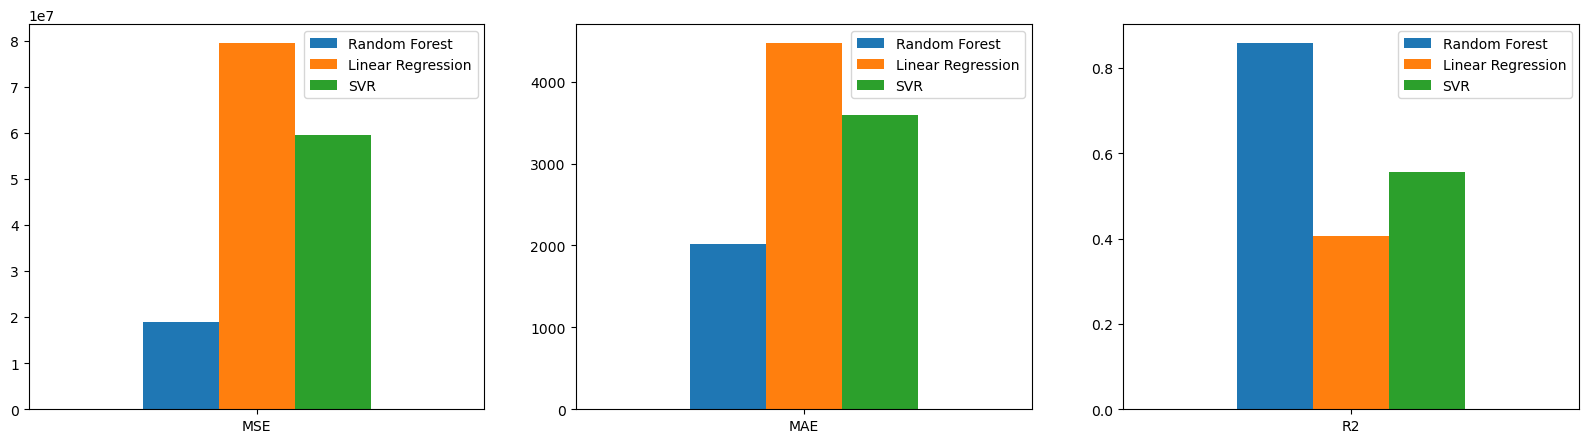

In [512]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'SVR': SVR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'SVR': SVR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'SVR': SVR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

In [513]:
print(df_r2)
print(df_mae)
print(df_mse)

    Random Forest  Linear Regression       SVR
R2        0.85887           0.406121  0.555365
     Random Forest  Linear Regression          SVR
MAE    2014.373742         4477.37455  3587.828595
     Random Forest  Linear Regression           SVR
MSE   1.890307e+07       7.954453e+07  5.955472e+07


## Conclusion
Random Forest has a lower MSE and MAE rate and a higher R2 score when compared to Linear Regression and SVR, indicating it is a better regressor to use.

1. MSE (mean squared error) - Lower value indicates a smaller error.  Due to square can be influenced by outliers.
1. MAE (mean absolute error) - Measures average absolute error between predicted and actual values.  0 would be a perfect prediction (unlikely).  Less sensitive to outliers in data
1. R2 - used to check how well observed results are reproduced by the model.  Best score is 1 (perfect).

Definitions
1. F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

1. The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The best value is 1 and the worst value is 0.
2. The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
3. The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.  The best value is 1 and the worst value is 0.

#### Data Dictionary / Columns (https://www.kaggle.com/datasets/mirichoi0218/insurance)

1. age: age of primary beneficiary
1. sex: insurance contractor gender, female, male
1. bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
1. children: Number of children covered by health insurance / Number of dependents
1. smoker: Smoking
1. region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
1. charges: Individual medical costs billed by health insurance